**Загрузка необходимых для работы бибилиотек**

In [1]:
from google.colab import files # Для работы с файлами 
import numpy as np # Для работы с данными 
import pandas as pd # Для работы с таблицами
import matplotlib.pyplot as plt # Для вывода графиков
import os # Для работы с файлами
%matplotlib inline

from tensorflow.keras import utils # Для работы с категориальными данными
from tensorflow.keras.models import Sequential # Полносвязная модель
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation # Слои для сети
from tensorflow.keras.preprocessing.text import Tokenizer # Методы для работы с текстами и преобразования их в последовательности
from tensorflow.keras.preprocessing.sequence import pad_sequences # Метод для работы с последовательностями

from sklearn.preprocessing import LabelEncoder # Метод кодирования тестовых лейблов
from sklearn.model_selection import train_test_split # Для разделения выборки на тестовую и обучающую
from google.colab import drive # Для работы с Google Drive
import time # Импортируем библиотеку time
from tensorflow.keras.callbacks import ModelCheckpoint # Для колбека
from keras.models import load_model # Для сохранения и загрузки модели
import re # Модуль работы с регулярными выражениями
import seaborn as sns # Библиотека для визуализации данных

In [2]:
from google.colab import drive # Подключаем гугл диск
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
# Загружаем фреймы
df = pd.read_csv(open('/content/drive/MyDrive/Базы/Обращения граждан/train_dataset_train.csv')) # Обучающий датасет
df_test = pd.read_csv(open('/content/drive/MyDrive/Базы/Обращения граждан/test_dataset_test.csv')) # Тестовый дата сет для сдачи
df

,id,Текст Сообщения,Тематика,Ответственное лицо,Категория
0,2246,Помогите начальник Льговского рэс не реагирует...,"Нарушения, связанные с содержанием электросети...",Администрация Льговского района,3
1,380,<p>По фасаду дома по адресу ул. Урицкого 22 пр...,Аварийные деревья,Администрация города Курска,3
2,2240,Агресивные собаки. На радуге там стая из подро...,Безнадзорные животные,Администрация города Курска,1
3,596,<p>На пересечении &nbsp;улиц Сосновская и Бере...,Нескошенная сорная растительность в местах общ...,Комитет дорожного хозяйства города Курска,3
4,1797,<p style=`text-align:justify;`><span style=`ba...,Аварийные деревья,Комитет городского хозяйства города Курска,3
...,...,...,...,...,...
1995,1356,<p>22.12.21 в вечернее время появилась вонь от...,Неприятные запахи,Комитет природных ресурсов Курской области,16
1996,243,<p>Добрый день! Хочу сообщить о такой проблеме...,Парковки на дорогах в границах городских округ...,Администрация города Курска,0
1997,2350,Состоят 3 засохшие дерева (2 большие берёзы и...,Аварийные деревья,Администрация города Курска,3
1998,1937,"Пожалуйста роман Владимирович, в скором времен...",Нарушение дорожного покрытия (ямы) на дорогах...,Администрация города Курска,0


**Визуализируем балансировку дата сета и подсчитываем её**

Количество записей категории 3 : 954
Количество записей категории 1 : 25
Количество записей категории 16 : 149
Количество записей категории 0 : 478
Количество записей категории 6 : 10
Количество записей категории 8 : 139
Количество записей категории 4 : 108
Количество записей категории 13 : 11
Количество записей категории 10 : 48
Количество записей категории 11 : 19
Количество записей категории 14 : 4
Количество записей категории 7 : 27
Количество записей категории 5 : 12
Количество записей категории 15 : 7
Количество записей категории 2 : 3
Количество записей категории 9 : 5
Количество записей категории 12 : 1


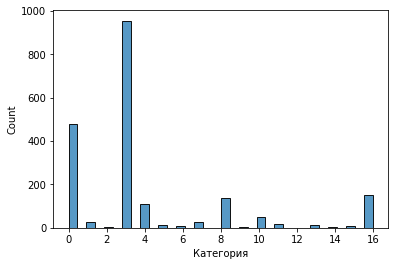

In [25]:
# Считаем расбалансировку 
for cl in df['Категория'].unique(): #Проходим по всем классам
  print('Количество записей категории', cl, ':', df[df['Категория'] == cl].shape[0])
sns.histplot(data=df.Категория) # Визуализируем расбалансировку

**Согласно полученным данным расбалансировки, принимаем следующее решение:**

- необходимо увеличить словарь слов
- необходимо увеличить количество признаков в обращениях

**Для этого необходимо объеденить все текстовые колонки и привести их к единому виду**

**Объединяем текстовые колонки**

In [26]:
df["Текст Сообщения"] = df["Текст Сообщения"].astype(str) + " " + df["Тематика"].astype(str) + " " + df["Ответственное лицо"].astype(str) # Объединяем
df.drop(df.columns[[2,3]], axis=1, inplace=True) # Удаляем объединенные колоки
df.head(3) # Выводим первые 3 строки дата сета

,id,Текст Сообщения,Категория
0,2246,Помогите начальник Льговского рэс не реагирует...,3
1,380,<p>По фасаду дома по адресу ул. Урицкого 22 пр...,3
2,2240,Агресивные собаки. На радуге там стая из подро...,1


**Предобрабатываем текстовые данные и приводим их к единому виду**

In [28]:
from string import punctuation  # Модуль для работы со строками

# Удаление символов пунктуации
def remove_punctuation(my_string):
    return "".join([ch if ch not in punctuation else ' ' for ch in my_string]) # Замена на пробелы!!!

# Удаление чисел
def remove_numbers(my_string):
    return ''.join([i if not i.isdigit() else ' ' for i in my_string])

# Замена множественных пробелов на одинарный пробел
import re
def remove_multiple_spaces(my_string):
	return re.sub(r'\s+', ' ', my_string, flags=re.I)

# Обработка строк + дополнительно приведение к нижнему регистру
preproccessing = lambda text: (remove_multiple_spaces(remove_numbers(remove_punctuation(text.lower())))) 

# Создаем колонку в датасете для обработанного текста
# Заменяем изначальный текст на предобработанный, без лишних знаков и приведением к нижнему регистру
df['Текст Сообщения'] = list(map(preproccessing, df['Текст Сообщения']))
df.head()

,id,Текст Сообщения,Категория
0,2246,помогите начальник льговского рэс не реагирует...,3
1,380,p по фасаду дома по адресу ул урицкого проход...,3
2,2240,агресивные собаки на радуге там стая из подрос...,1
3,596,p на пересечении nbsp улиц сосновская и берег...,3
4,1797,p style text align justify span style backgro...,3


**Приводим текст обращений к словарной форме**

In [29]:
!pip install pymorphy2            # pymorphy2 - морфологический анализатор для русского языка
!pip install pymorphy2-dicts      # пакет со словарями
!pip install DAWG-Python  

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 3.0 MB/s 
     |████████████████████████████████| 8.2 MB 14.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.1 MB 6.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
# NLTK - библиотек Python для решения задач обработки естественного языка
import nltk

from nltk.stem.snowball import SnowballStemmer    # Стеммер Porter2 - новая версия стеммера Портера
from nltk.corpus import stopwords                 # Библиотека стоп-слов
from nltk import word_tokenize                    # Токенизатор

nltk.download('stopwords')                        # Загрузка стоп-слов
nltk.download('punkt')                            # Загрузка символов пунктуации
stemmer = SnowballStemmer("russian")              # Стеммер для русского языка

russian_stopwords = stopwords.words("russian")    # Список стоп-слов для русского языка
# Расширение списка стоп-слов (см. набор данных)
russian_stopwords.extend(['…', '«', '»', '...', 'т.д.', 'т', 'д', 'nan', 'p', '/', '\'', '<', '>'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [33]:
# Провердим лемматизацию и избавляемся от стоп-слов
lemm_texts_column = []
for text in df['Текст Сообщения']:
    tokens = word_tokenize(text)    
    lemmed_tokens = [morph.parse(token)[0].normal_form for token in tokens if token not in russian_stopwords]
    text = " ".join(lemmed_tokens)
    lemm_texts_column.append(text)
    
# Заменяем существующие тексты на лемматизированные
df['Текст Сообщения'] = lemm_texts_column
df['Текст Сообщения'][0] # Выводим пример первой строки дата сета

'помочь начальник льговский рэс реагировать жалоба малый ветер сидеть свет именно деревня больший угон улица старый слобода пожалуйста помочь пускай вычистить фотоотчёт сделать нарушение связанный содержание электросеть качество энергоснабжение район частное сектор администрация льговский район'

**Нормализуем датасет для обучения нейронной сети**

In [58]:
texts = df['Текст Сообщения'].values # Извлекаем данные всех текстов из столбца 'Текст Сообщения'
classes = list(df['Категория'].values) # Извлекаем соответствующие им значения классов (лейблов) столбца 'Текст Сообщения'
maxWordsCount = 9000 # Зададим максимальное количество слов/индексов, учитываемое при обучении текстов

print(df['Категория'].unique()) # Выводим все уникальные значения классов
nClasses = df['Категория'].nunique() # Задаём количество классов, обращаясь к столбцу 'Категория' и оставляя уникальные значения
print('Количество классов =', nClasses) # Посмотрим на количество классов

[ 3  1 16  0  6  8  4 13 10 11 14  7  5 15  2  9 12]
Количество классов = 17


In [38]:
#Преобразовываем текстовые данные в числовые/векторные для обучения нейросетью
#Для этого воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
#num_words=maxWordsCount - определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
#filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n' - избавляемся от ненужных символов
#lower=True - приводим слова к нижнему регистру
#split=' ' - разделяем слова по пробелу
#char_level=False - просим токенайзер не удалять однобуквенные слова
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', oov_token='unknown', char_level=False)#False

tokenizer.fit_on_texts(texts) # Даём в обработку наши тексты, методу, который соберет словарь частотности

# Формируем матрицу индексов по принципу Bag of Words
xAll = tokenizer.texts_to_matrix(texts) # Каждое слово из текста нашло свой индекс в векторе длиной maxWordsCount и отметилось в нем единичкой 
print(xAll.shape)  # Посмотрим на форму текстов
print(xAll[0, :20])# И отдельно на фрагмент начала вектора

(2000, 9000)
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.]


In [40]:
# Посмотрим размер словаря
print("Размер словаря", len(tokenizer.word_index.items()))

Размер словаря 8711


In [46]:
#Преобразовываем категории в векторы
encoder = LabelEncoder() # Вызываем метод кодирования тестовых лейблов из библиотеки sklearn
encoder.fit(classes) # Подгружаем в него категории из нашей базы
classesEncoded = encoder.transform(classes) # Кодируем категории
print('Посмотрим кодированные категории', encoder.classes_) # Посмотрим кодированные категории
print('Количество',classesEncoded.shape)
print('Посмотрим как выглядят первые 17 категорий', classesEncoded[:17])

yAll = utils.to_categorical(classesEncoded, nClasses) # И выводим каждый лейбл в виде вектора длиной 17, с 1кой в позиции соответствующего класса и нулями
print('Форма лейблов', yAll.shape) # Посмотрим на форму лейблов категорий
print('Первая строка лейблов',yAll[0]) # И отдельно на первую строку

Посмотрим кодированные категории [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Количество (2000,)
Посмотрим как выглядят первые 17 категорий [ 3  3  1  3  3  3  3 16  3  0  0  3  3  3  0  3  3]
Форма лейблов (2000, 17)
Первая строка лейблов [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [47]:
# разбиваем все данные на обучающую и тестовую выборки с помощью метода train_test_split из библиотеки sklearn
xTrain, xVal, yTrain, yVal = train_test_split(xAll, yAll, test_size=0.2, shuffle = True) # Берем 20% на тестовую выборку и перемешиваем данные
print(xTrain.shape) #посмотрим на форму текстов из обучающей выборки
print(yTrain.shape) #и на форму соответсвующих им классов

(1600, 9000)
(1600, 17)


**Сохранение весов модели для выбора наилучшей эпохи**

In [48]:
# Сохраняем сеть на каждой эпохе
# {epoch:02d} - номер эпохи
# {val_acc:.4f} - значение аккуратности на проверочном ноборе данных
callbacks = [ModelCheckpoint('save_models/Appeals_of_citizens-{epoch:02d}-{loss:.4f}.hdf5')]
# Сохраняем только лучший вариант сети
#callbacks = [ModelCheckpoint('save/Kursk-text.hdf5', monitor='val_loss', save_best_only=True)]

**Обучаем нейронную сеть**

Epoch 1/30
25/25 - 1s - loss: 2.1803 - accuracy: 0.4663 - val_loss: 1.3279 - val_accuracy: 0.6775 - 1s/epoch - 51ms/step
Epoch 2/30
25/25 - 0s - loss: 1.0599 - accuracy: 0.6894 - val_loss: 0.6659 - val_accuracy: 0.7975 - 359ms/epoch - 14ms/step
Epoch 3/30
25/25 - 1s - loss: 0.5511 - accuracy: 0.8425 - val_loss: 0.4109 - val_accuracy: 0.9025 - 513ms/epoch - 21ms/step
Epoch 4/30
25/25 - 1s - loss: 0.3360 - accuracy: 0.9119 - val_loss: 0.3084 - val_accuracy: 0.9200 - 650ms/epoch - 26ms/step
Epoch 5/30
25/25 - 1s - loss: 0.2130 - accuracy: 0.9438 - val_loss: 0.2884 - val_accuracy: 0.9250 - 574ms/epoch - 23ms/step
Epoch 6/30
25/25 - 1s - loss: 0.1662 - accuracy: 0.9506 - val_loss: 0.2554 - val_accuracy: 0.9325 - 667ms/epoch - 27ms/step
Epoch 7/30
25/25 - 1s - loss: 0.1395 - accuracy: 0.9613 - val_loss: 0.2575 - val_accuracy: 0.9425 - 824ms/epoch - 33ms/step
Epoch 8/30
25/25 - 1s - loss: 0.1185 - accuracy: 0.9644 - val_loss: 0.2388 - val_accuracy: 0.9450 - 690ms/epoch - 28ms/step
Epoch 9/30


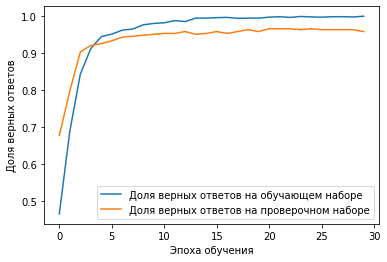

In [49]:
#Создаём полносвязную сеть
model = Sequential()
#Входной полносвязный слой
model.add(Dense(100, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model.add(Dropout(0.2)) 
#Второй полносвязный слой
model.add(Dense(100, activation='relu'))
#Слой регуляризации Dropout
model.add(Dropout(0.3))
#Третий полносвязный слой
model.add(Dense(100, activation='relu'))
#Слой регуляризации Dropout
model.add(Dropout(0.4))
#Выходной полносвязный слой
model.add(Dense(nClasses, activation='softmax'))#softmax, sigmoid
time_start = [time.time()]

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем сеть на выборке
history = model.fit(xTrain, 
                    yTrain, 
                    epochs=30,
                    batch_size=64,
                    validation_data=(xVal, yVal),
                    verbose=2,
                    callbacks=callbacks)

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [57]:
# 28 эпоха оказалась лучшей
# Загружаем эпоху из дериктории
#model = load_model('/content/save_models/Appeals_of_citizens-28-0.0098.hdf5')
# Перезаписываем на диск
model.save('/content/drive/MyDrive/Предобученные сети/Курск/Финальный вариант/Appeals_of_citizens-28-v_ac_0.9625.hdf5')

# **Предиктим (распознаем № категории по тексту обращения) тестовый датасет**

In [51]:
# Загружаем тестовый датасет
df_test = pd.read_csv(open('/content/drive/MyDrive/Базы/Обращения граждан/test_dataset_test.csv'))
# Удаляем не нужные колоки 
df_test.drop(df_test.columns[[2,3]], axis=1, inplace=True)
df_test.head(3) # Смотрим

,id,Текст Сообщения
0,843,<p>Здравствуйте. На улице Мира &nbsp;было заме...
1,1422,<p>Уже вторую неделю не горит уличное освещени...
2,2782,Не работает освещение во дворе дома 11а по Эне...


**Выполним такуюже пред обработку текста на которой обучалась нейронка**

In [52]:
# Удаление символов пунктуации
def remove_punctuation(my_string):
    return "".join([ch if ch not in punctuation else ' ' for ch in my_string]) # Замена на пробелы!!!
# Удаление чисел
def remove_numbers(my_string):
    return ''.join([i if not i.isdigit() else ' ' for i in my_string])
# Замена множественных пробелов на одинарный пробел
import re
def remove_multiple_spaces(my_string):
	return re.sub(r'\s+', ' ', my_string, flags=re.I)
# Обработка строк + дополнительно приведение к нижнему регистру
preproccessing = lambda text: (remove_multiple_spaces(remove_numbers(remove_punctuation(text.lower())))) 
# Создаем колонку в датасете для обработанного текста
df_test['Текст Сообщения'] = list(map(preproccessing, df_test['Текст Сообщения']))
df_test.head()

,id,Текст Сообщения
0,843,p здравствуйте на улице мира nbsp было замене...
1,1422,p уже вторую неделю не горит уличное освещени...
2,2782,не работает освещение во дворе дома а по энерг...
3,2704,после покоса сорной растительности на газоне м...
4,1,p прошу принять меры к водителю маршрута пос ...


In [53]:
# Выполним лемметизацию текста
lemm_texts_column_test = []
for text in df_test['Текст Сообщения']:
    tokens = word_tokenize(text)    
    lemmed_tokens = [morph.parse(token)[0].normal_form for token in tokens if token not in russian_stopwords]
    text = " ".join(lemmed_tokens)
    lemm_texts_column_test.append(text)
    
# Создаем новую колонку в наборе данных
df_test['Текст Сообщения'] = lemm_texts_column_test
df_test['Текст Сообщения'][0]

'здравствуйте улица мир nbsp заменить наружное освещение именно заменить лампа nbsp энергосберегающий лампа протяжение несколько месяц освещение улица отсутствовать последний улица осветить это зима приблизительно каждый день человек работать часовой смена многие возвращаться очень поздно дать проблема улица посёлок nbsp'

**Определим категорию текста обращения и выведем её в новый столбец**

In [54]:
test_mess = np.array(df_test['Текст Сообщения']) # Переводим сообщения в массив
x = tokenizer.texts_to_matrix(test_mess) # Токенизируем массив

prediction = model.predict(x)

for i in range(len(x)): # Циклом проходимся по токенизированному массиву
  df_test.loc[i,'Категория'] = np.argmax(prediction[i]) # Присваеваем категорию каждому обращению 
df_test = df_test.astype({'Категория':'Int64'}) # Переводим цифры в целочисленный формат
df_test # Смотрим что получилось

,id,Текст Сообщения,Категория
0,843,здравствуйте улица мир nbsp заменить наружное ...,3
1,1422,второй неделя гореть уличный освещение nbsp,0
2,2782,работать освещение двор дом энергетик световой...,3
3,2704,покос сорный растительность газон тротуар прое...,3
4,1,просить принять мера водитель маршрут пос севе...,8
...,...,...,...
995,2619,добрый день семья житель пос волокно просыпать...,16
996,2518,лазарев г щигры ветка тополь скоро выбить стек...,3
997,2524,вход комитет образование курск ям дорога,0
998,1577,добрый время сутки пол год медотвод вакцинация...,4


**Приводим тестовый набор к формату для сдачи жури**

In [55]:
# Удаляем колонку с текстом 
df_test.drop(df_test.columns[[1]], axis=1, inplace=True)

In [56]:
# Сохраняем файл в формете .csv без индексов
df_test.to_csv('/content/drive/MyDrive/Предобученные сети/Курск/Финальный вариант/df_test_predobr.csv', index=False)